<a href="https://colab.research.google.com/github/es2mac/SwiftDigger/blob/master/TetrisField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ideas

Next steps:
- Improve constructFeaturePlanes performance, ditching ShapedArray
- Try model training, figure out model saving/loading
- Use enum to mark selection result from each node (existing node, uninitiated at index, unavailable because children are not setup yet)
- Implement finding SRS twist moves
- Implement parallel search with virtual loss
- Consider terminal nodes
- Dynamically compose field with a limited number of garbage

MCTS (my implementation, not exactly as commonly described):
- Start from root node, select best child until we find one that hasn't been evaluated
  - "Best" includes priors, and balances exploration & exploitation
  - Internally, this node is freshly initiated at this selection step
- Prepare this node for evaluation, and set up for possible future visits
  - Find all valid children
  - Based on the number of valid children, initiate children N, W
- Evaluate the node
  - Get value of this node, and set priors for its children
  - Backpropagate the value


Notes on crafting features:
- Simple value ideas (working thought below) didn't work well.  The bot plays too greedy and has no idea what to do if no line is cleared.  It can't see far enough.  In retrospect, this is not surprising, because I've skimped the rollout part of the basic MCTS.

Working thought:

- An NN model needs to be able to handle 0~5 previews when doing MCTS for a real game that has 5 previews.  Cases with more previews seems more important, but cases with less previews are used far more often in that type of search (if time permits).  In fact, if we often get down to 3 previews or fewer (tree depth >2), maybe it's reasonable to shrink the model to only handle fewer previews?  On the other hand, with very few or no preview, there shouldn't be enough information to know with any certainty whether the next few lines could be cleared quickly.  It's very situational.

- Value function.  The general idea is "piece/line ratio."  One idea is that only garbage lines matter, don't reward clearing lines made with player pieces.  The other is whether we do 
  - How many pieces for the next N lines, or
  - How many lines for the next N pieces
  - Some complicated combo, fixing neither line nor piece count?

- Say I use the number of pieces for the next 4 garbage lines.  My value could be linear, or could be 4/n where the max value is 1.  Questions here:
  - Does this curve work well, in the context of UCT? (might need to try and see)
  - Does N=4 make sense?  4/4 is very possible, and the risk is whether this is too short-sighted.  On the other hand, if I use say N=10, the signal may be too weak because in such long-term, a single placement doesn't affect the final piece count very much.
  
- For RL's early stage, maybe I could set up a simplified problem, say given N=7 pieces (i.e. play, hold, and 5 previews), try to clear as many lines as possible.  Increase N once it gets off the ground.

References:
- The most relevant reference is [MiniGo in Swift](https://github.com/tensorflow/swift-models/tree/master/MiniGo), as well as the [original MiniGo](https://github.com/tensorflow/minigo).
- [MCTS with Python explanation](http://www.moderndescartes.com/essays/deep_dive_mcts/), some interesting implementation details to think about.
- [Nice of medium posts](https://medium.com/oracledevs/lessons-from-alphazero-part-3-parameter-tweaking-4dceb78ed1e5) on AlphaZero.
- [El-Tetris](http://imake.ninja/el-tetris-an-improvement-on-pierre-dellacheries-algorithm/) [source code](https://github.com/daogan/tetris-ai/blob/master/tetris_ai.py) has some clarifications of hand-crafted features.



# Notebook Setup

In [0]:
import Foundation
import Python
import TensorFlow

%include "EnableIPythonDisplay.swift"
_ = IPythonDisplay.shell.enable_matplotlib("inline")

let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

// print(Python.version)

# Tetris Types: Tetromino, Piece, Field

In [0]:
/// Just the type of a tetromino.
enum Tetromino: Int, CaseIterable {
  case I, J, L, O, S, T, Z  // In alphabetical order
}

public func < <T: RawRepresentable>(a: T, b: T) -> Bool where T.RawValue: Comparable {
    return a.rawValue < b.rawValue
}

extension Tetromino: Comparable {}

extension Tetromino: CustomDebugStringConvertible {
  public var debugDescription: String {
    switch self {
      case .I: return "I"
      case .J: return "J"
      case .L: return "L"
      case .O: return "O"
      case .S: return "S"
      case .T: return "T"
      case .Z: return "Z"
    }
  }
}

In [0]:
/// A piece is a tetromino with placement information.  Calling it "Piece"
/// instead of "Placement" to be intentionally ambiguous, to use in different
/// contexts where we need to describe more than just the Tetromino type.
struct Piece {
  enum Orientation: Int, CaseIterable {
      case up, right, down, left
  }

  let type: Tetromino
  var x: Int
  var y: Int
  var orientation: Orientation = .up
}

extension Piece: Hashable {
  var hashValue: Int {
    return ((x + y * 10) << 5) | (type.rawValue << 2) | orientation.rawValue
  }
}

// Piece conforms to CustomDebugStringConvertible, but it needs some constants defined later
// extension Piece: CustomDebugStringConvertible {}

extension Piece {
  /// This index is used as index to construct & access some constants
  var typeAndOrientationIndex: Int {
    get { return type.rawValue * 4 + orientation.rawValue }
  }
}

In [0]:
/// The game field is really just an array of rows.
/// It can be any number of rows tall.
struct Field {
  /// Each row is stored as bits in an Int16.
  /// By convention, empty top rows should be removed, no empty row.
  var storage: [Int16]
  var height: Int { return storage.count }
  var garbageCount: Int
}

extension Field {
  init() {
    self.storage = []
    self.garbageCount = 0
  }
}

extension Field: CustomDebugStringConvertible {
  public var debugDescription: String {
    var lines = storage.map { (n: Int16) -> String in
      let binaryString = String(n, radix: 2)
      let padding =  String(repeating: "0", count: (10 - binaryString.count))
      return padding + binaryString + "  "
    }
    if (garbageCount > 0) && (garbageCount <= lines.count) {
      lines[garbageCount - 1] = "==< " + lines[garbageCount - 1]
    }
    return String(lines.joined(separator: "\n").reversed())
             .replacingOccurrences(of: "0", with: "  ")
             .replacingOccurrences(of: "1", with: "O ")
  }
}
    
extension Field: Hashable {
  var hashValue: Int {
    return self.storage.reduce(garbageCount) { ($0 << 3) ^ Int($1) }
  }
}

# Field Methods

### Construct bitmasks of piece for placement check

In [0]:
/**
"Unshifted" means additional x/y shifting needs to happen when using these.

 Because pieces extend to the left and down of the piece center, these masks
 uniformally start from 2 blocks left of the center, and starts from the
 bottom-most row of the piece.  An additional offset is constructed for where
 that bottom row is with respect to the piece center.

 In other words, when using these masks to check a piece on the field:
 1) Shift by piece's x position, then back 2 bits
 2) Shift by piece's y position, minus the bottom row offset

 Ref: https://harddrop.com/wiki/SRS
 */
func makeUnshiftedPieceBitmasks(type: Tetromino, orientation: Piece.Orientation) -> [Int16] {
  switch (type, orientation) {
    case (.I, .up)   : return [0b11110]
    case (.I, .right): return [0b100, 0b100, 0b100, 0b100]
    case (.I, .down) : return [0b1111]
    case (.I, .left) : return [0b100, 0b100, 0b100, 0b100]
    case (.J, .up)   : return [0b1110, 0b10]
    case (.J, .right): return [0b100, 0b100, 0b1100]
    case (.J, .down) : return [0b1000, 0b1110]
    case (.J, .left) : return [0b110, 0b100, 0b100]
    case (.L, .up)   : return [0b1110, 0b1000]
    case (.L, .right): return [0b1100, 0b100, 0b100]
    case (.L, .down) : return [0b10, 0b1110]
    case (.L, .left) : return [0b100, 0b100, 0b110]
    case (.O, .up)   : return [0b1100, 0b1100]
    case (.O, .right): return [0b1100, 0b1100]
    case (.O, .down) : return [0b110, 0b110]
    case (.O, .left) : return [0b110, 0b110]
    case (.S, .up)   : return [0b110, 0b1100]
    case (.S, .right): return [0b1000, 0b1100, 0b100]
    case (.S, .down) : return [0b110, 0b1100]
    case (.S, .left) : return [0b100, 0b110, 0b10]
    case (.T, .up)   : return [0b1110, 0b100]
    case (.T, .right): return [0b100, 0b1100, 0b100]
    case (.T, .down) : return [0b100, 0b1110]
    case (.T, .left) : return [0b100, 0b110, 0b100]
    case (.Z, .up)   : return [0b1100, 0b110]
    case (.Z, .right): return [0b100, 0b1100, 0b1000]
    case (.Z, .down) : return [0b1100, 0b110]
    case (.Z, .left) : return [0b10, 0b110, 0b100]
  }
}

In [0]:
func getBottomRowOffset(type: Tetromino, orientation: Piece.Orientation) -> Int {
  switch (type, orientation) {
    case (.I, .up)   : return 0
    case (.I, .right): return 2
    case (.I, .down) : return 0
    case (.I, .left) : return 1
    case (.J, .up)   : return 0
    case (.J, .right): return 1
    case (.J, .down) : return 1
    case (.J, .left) : return 1
    case (.L, .up)   : return 0
    case (.L, .right): return 1
    case (.L, .down) : return 1
    case (.L, .left) : return 1
    case (.O, .up)   : return 0
    case (.O, .right): return 1
    case (.O, .down) : return 1
    case (.O, .left) : return 0
    case (.S, .up)   : return 0
    case (.S, .right): return 1
    case (.S, .down) : return 1
    case (.S, .left) : return 1
    case (.T, .up)   : return 0
    case (.T, .right): return 1
    case (.T, .down) : return 1
    case (.T, .left) : return 1
    case (.Z, .up)   : return 0
    case (.Z, .right): return 1
    case (.Z, .down) : return 1
    case (.Z, .left) : return 1
  }
}

I'm unsure about the performance of this double enum switching, so I'm composing them into plain arrays with my own indexing scheme.

It might be interesting to compare the performance of calling the above functions vs. arrays.

In [0]:
let unshiftedPieceBitmasks: [[Int16]] = { () -> [[Int16]] in
  var masks = [[Int16]](repeating: [], count: 7 * 4)
  for type in Tetromino.allCases {
    for orientation in Piece.Orientation.allCases {
      let piece = Piece(type: type, x: 0, y: 0, orientation: orientation)
      masks[piece.typeAndOrientationIndex] = makeUnshiftedPieceBitmasks(type: type, orientation: orientation)
    }
  }
  return masks
}()

let unshiftedWholePieceBitmasks: [Int] = unshiftedPieceBitmasks.map { lineMasks in
  lineMasks.reversed().reduce(0, { (wholeMask, lineMask) in
    (wholeMask << 10) | Int(lineMask)
  })
}

let bottomRowOffsets: [Int] = { () -> [Int] in
  var offsets = [Int](repeating: 0, count: 7 * 4)
  for type in Tetromino.allCases {
    for orientation in Piece.Orientation.allCases {
      let piece = Piece(type: type, x: 0, y: 0, orientation: orientation)
      offsets[piece.typeAndOrientationIndex] = getBottomRowOffset(type: type, orientation: orientation)
    }
  }
  return offsets  
}()

In [0]:
// Now I can draw ASCII representations of Piece
extension Piece: CustomDebugStringConvertible {
  public var debugDescription: String {
      let masks = unshiftedPieceBitmasks[typeAndOrientationIndex]
      var lines = masks.map {
        String($0, radix: 2)
          .replacingOccurrences(of: "0", with: " ")
          .replacingOccurrences(of: "1", with: "X")
      }
    
      var joinedLines = String(lines.joined(separator: "\n").reversed())
      joinedLines += String(repeating: " ", count: 6 - lines.last!.count)
      joinedLines += "(\(x), \(y))\n"
      return "\n" + joinedLines
  }
}

### Constants for simple dropping positions

In [0]:
/// Tetromino's starting placements are x-coordinates + orientations reached by
/// 2-step finesse, without obstruction and disregarding y-coordinates.
/// Hard-dropping from here becomes a "simple placement," below.

typealias StartingPlacement = (x: Int, orientation: Piece.Orientation)

let placementsO: [StartingPlacement] =
  [(x: 0, orientation: .up),
   (x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up)]

let placementsI: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),

   (x: 0, orientation: .left),
   (x: 1, orientation: .left),
   (x: 2, orientation: .right),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 7, orientation: .left),
   (x: 8, orientation: .right),
   (x: 9, orientation: .right)]

let placementsSZ: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up),

   (x: 1, orientation: .left),
   (x: 1, orientation: .right),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 4, orientation: .right),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 8, orientation: .left),
   (x: 8, orientation: .right)]

let placementsJLT: [StartingPlacement] =
  [(x: 1, orientation: .up),
   (x: 2, orientation: .up),
   (x: 3, orientation: .up),
   (x: 4, orientation: .up),
   (x: 5, orientation: .up),
   (x: 6, orientation: .up),
   (x: 7, orientation: .up),
   (x: 8, orientation: .up),

   (x: 0, orientation: .right),
   (x: 1, orientation: .right),
   (x: 2, orientation: .right),
   (x: 3, orientation: .right),
   (x: 4, orientation: .right),
   (x: 5, orientation: .right),
   (x: 6, orientation: .right),
   (x: 7, orientation: .right),
   (x: 8, orientation: .right),

   (x: 1, orientation: .down),
   (x: 2, orientation: .down),
   (x: 3, orientation: .down),
   (x: 4, orientation: .down),
   (x: 5, orientation: .down),
   (x: 6, orientation: .down),
   (x: 7, orientation: .down),
   (x: 8, orientation: .down),

   (x: 1, orientation: .left),
   (x: 2, orientation: .left),
   (x: 3, orientation: .left),
   (x: 4, orientation: .left),
   (x: 5, orientation: .left),
   (x: 6, orientation: .left),
   (x: 7, orientation: .left),
   (x: 8, orientation: .left),
   (x: 9, orientation: .left)]

func getStartingPlacements(type: Tetromino) -> [StartingPlacement] {
   switch type {
     case .J, .L, .T: return placementsJLT
     case .S, .Z: return placementsSZ
     case .O: return placementsO
     case .I: return placementsI
   }
}

### Check if a piece can be placed on the field

In [0]:
extension Field {

  func canPlace(_ piece: Piece) -> Bool {

    // Only need to check for obstruction in rows that exist
    let index = piece.typeAndOrientationIndex
    let bottomRow = piece.y - bottomRowOffsets[index]
    guard bottomRow < storage.count else { return true }

    let pieceMasks = unshiftedPieceBitmasks[index]
    let numberOfRowsToCheck = min(pieceMasks.count, storage.count - bottomRow)
    
    for i in 0 ..< numberOfRowsToCheck {
      let row = storage[bottomRow + i]
      if row & (pieceMasks[i] << (piece.x - 2)) != 0 { return false }
    }
    
    return true
  }

}

### Find all possible simple (hard-dropped from top) placements of tetrominos

In [0]:
extension Field {

  /// Combine as many lines as an Int would hold, for faster piece checks
  /// Also: shift by 2 to work with piece masks
  var multiLineMasks: [Int] {
    get {
      var masks = storage.map(Int.init)
      for i in (1 ..< masks.count).reversed() {
        masks[i - 1] |= (masks[i] << 10)
      }
      return masks
    }
  }

  /// Simple placements are those reached by shifting & rotating first
  /// at the top of the field, then dropped straight down.
  /// That is, no soft-drop then shift or twist.
  func findAllSimplePlacements(for types: [Tetromino]) -> [Piece] {
    
    let lineMasks = multiLineMasks
    
    var pieces: [Piece] = types.flatMap { type in
      getStartingPlacements(type: type).map {
        Piece(type: type, x: $0.x, y: 0, orientation: $0.orientation)
      }
    }    
    for i in 0 ..< pieces.count {
      let index = pieces[i].typeAndOrientationIndex
      let mask = unshiftedWholePieceBitmasks[index] << (pieces[i].x - 2)
      let bottomOffset = bottomRowOffsets[index]      
      var bottomRow = storage.count      
      while bottomRow > 0, (lineMasks[bottomRow-1] & mask) == 0 {
        bottomRow -= 1
      }
      pieces[i].y = bottomRow + bottomOffset
    }
    return pieces
  }
}

### Place (lock down) a piece

In [0]:
extension Field {
  /// Returns a copy of the field with a piece placed in, and lines cleared.
  /// "Paste" the piece right onto the field, does not check if it's legal.
  /// However, it is assumed that e.g. if the piece spans rows 7~9, then
  /// the field must already have at least 6 rows.  This would be true if
  /// the piece locked legally.
  func lockDown(_ piece: Piece) -> (newField: Field, garbageCleared: Int) {
    
    let index = piece.typeAndOrientationIndex
    let pieceMasks = unshiftedPieceBitmasks[index]
    let bottomRow = piece.y - bottomRowOffsets[index]

    var newStorage = storage

    // Append or OR in the mask
    for (i, var mask) in pieceMasks.enumerated() {
      mask <<= (piece.x - 2)
      let row = bottomRow + i
      if row >= newStorage.count {
        newStorage.append(mask)
      } else {
        newStorage[row] |= mask
	    }
    }
    
    // Remove filled rows
    var garbageCleared = 0
    var newGarbageCount = garbageCount
    var checkRow = bottomRow
    for _ in 0 ..< pieceMasks.count {
      if newStorage[checkRow] == 0b11111_11111 {
        newStorage.remove(at: checkRow)
        if (checkRow < newGarbageCount) {
          garbageCleared += 1
          newGarbageCount -= 1
        }
      } else {
        checkRow += 1
      }
    }

    return (newField: Field(storage: newStorage, garbageCount: newGarbageCount),
            garbageCleared: garbageCleared)
  }
}
  

# Game Methods

### Generators

In [0]:
class PieceGenerator {
  private var storage: [Tetromino] = []
  
  var offset = 0

  init() {}
  
  subscript(index: Int) -> Tetromino {
    get {
      let internalIndex = index + offset
      while internalIndex >= storage.count {
        storage.append(contentsOf: Tetromino.allCases.shuffled())
      }
      return storage[internalIndex]
    }    
  }
}

class GarbageGenerator {
  private var holePositions: [Int] = [Int.random(in: 0..<10)]
  
  var offset = 0

  init() {}
  
  subscript(index: Int) -> Int16 {
    get {
      let internalIndex = index + offset
      while internalIndex >= holePositions.count {
        let lastHolePosition = holePositions.last!
        holePositions.append((lastHolePosition + Int.random(in: 1..<10)) % 10)
      }
      return 0b11111_11111 ^ (1 << holePositions[internalIndex])
    }    
  }
}

# NN Model

### Components

In [0]:
struct ConvBN: Layer {
  var conv: Conv2D<Float>
  var norm: BatchNorm<Float>

  init(filterShape: (Int, Int, Int, Int), strides: (Int, Int) = (1, 1), padding: Padding = .same) {
    self.conv = Conv2D(filterShape: filterShape, strides: strides, padding: padding)
    self.norm = BatchNorm(featureCount: filterShape.3)
  }

  @differentiable
  func call(_ input: Tensor<Float>) -> Tensor<Float> {
      return input.sequenced(through: conv, norm)
  }
}

In [0]:
struct ResidualBlock: Layer {
  var layer1: ConvBN
  var layer2: ConvBN

  init(featureCount: Int, kernelSize: Int = 3) {
    self.layer1 = ConvBN(filterShape: (kernelSize, kernelSize, featureCount, featureCount))
    self.layer2 = ConvBN(filterShape: (kernelSize, kernelSize, featureCount, featureCount))
  }

  @differentiable
  func call(_ input: Tensor<Float>) -> Tensor<Float> {
    let layersOutput = layer2(relu(layer1(input)))
    return relu(layersOutput + input)
  }
}

In [0]:
/// Policy is softmax'd logits, shaped (10, 20, 8), i.e. (x, y, piece+orientation)
/// Last dimension (8) consists of the 4 orientations of the hold piece,
/// and then 4 for the play piece
struct TetrisModelOutput: Differentiable {
  let policy: Tensor<Float>
  let value: Tensor<Float>
  let logits: Tensor<Float>
}

// Modified from Transformer model, wrapping struct init in a differentiable function
@differentiable(wrt: (policy, value, logits), vjp: _vjpMakeTetrisModelOutput)
func makeTetrisModelOutput(policy: Tensor<Float>, value: Tensor<Float>, logits: Tensor<Float>) -> TetrisModelOutput {
 return TetrisModelOutput(policy: policy, value: value, logits: logits)
}

func _vjpMakeTetrisModelOutput(policy: Tensor<Float>, value: Tensor<Float>, logits: Tensor<Float>)
  -> (TetrisModelOutput, (TetrisModelOutput.CotangentVector) -> (Tensor<Float>, Tensor<Float>, Tensor<Float>)) {
  let result = TetrisModelOutput(policy: policy, value: value, logits: logits)
  return (result, { seed in (seed.policy, seed.value, seed.logits) })
}

In [0]:
// Copied from CIFAR helper, because control flow (e.g. looping) is not yet differentiable
extension Array where Element: Differentiable {
    @differentiable(wrt: (self, initialResult), vjp: reduceDerivative)
    func differentiableReduce<Result: Differentiable>(
        _ initialResult: Result,
        _ nextPartialResult: @differentiable (Result, Element) -> Result
    ) -> Result {
        return reduce(initialResult, nextPartialResult)
    }
    
    func reduceDerivative<Result: Differentiable>(
        _ initialResult: Result,
        _ nextPartialResult: @differentiable (Result, Element) -> Result
    ) -> (Result, (Result.CotangentVector) -> (Array.CotangentVector, Result.CotangentVector)) {
        var pullbacks: [(Result.CotangentVector)
            -> (Result.CotangentVector, Element.CotangentVector)] = []
        let count = self.count
        pullbacks.reserveCapacity(count)
        var result = initialResult
        for element in self {
            let (y, pb) = Swift.valueWithPullback(at: result, element, in: nextPartialResult)
            result = y
            pullbacks.append(pb)
        }
        return (value: result, pullback: { cotangent in
            var resultCotangent = cotangent
            var elementCotangents = CotangentVector([])
            elementCotangents.base.reserveCapacity(count)
            for pullback in pullbacks.reversed() {
                let (newResultCotangent, elementCotangent) = pullback(resultCotangent)
                resultCotangent = newResultCotangent
                elementCotangents.base.append(elementCotangent)
            }
            return (CotangentVector(elementCotangents.base.reversed()), resultCotangent)
        })
    }
}

### Model size calculation

Input:

- Assuming a 10 * 20 field, times channels
- 1 channel for the field
- 7 * 2 channels for hold and play pieces
- 7 * N channels for N previews
- Take N = 3, for 36 channels, for an input size of 7200

initialConv: 

- For most ConvBN, say we use 3x3 kernels
- Use width / channel count of 32, then 3 * 3 * 36 * 32 = 10368
- Bias for each channel, and batch norm params
- Say about 10k params here

residualBlocks: 

- Each has two ConvBN with 3 * 3 * 32 * 32, so 20k params
- Arbitrarily take 4 blocks, 80k params

policyConv1:

- Say 10k params

policyConv2:

- 32 channels to 8, 2~3k params

valueConv: 

- 1x1 ConvBN squashing to 1 channel, should be small

valueDense1: 

- From 200 to 32, so just over 6k

valueDense2: 

- Produce a single number... small

Output:

- (field size) * (hold or play piece) * (orientation)
- 200 * 2 * 4 = 1600

Shooting for an overall model size of 100~150k.

### TetrisModel

In [0]:
// This, ConvBN, ResidualBlock etc. modified from minigo
struct TetrisModel: Layer {

  var initialConv: ConvBN
  var residualBlocks: [ResidualBlock]

  var policyConv1: ConvBN
  var policyConv2: ConvBN

  var valueConv: ConvBN
  var valueDense1: Dense<Float>
  var valueDense2: Dense<Float>

  init(blockCount: Int = 4) {

    let inputFeatureCount = 36
    let convWidth = 32
    let valueDenseWidth = 32

    initialConv = ConvBN(filterShape: (3, 3, inputFeatureCount, convWidth))
    residualBlocks = (1...blockCount).map { _ in ResidualBlock(featureCount: convWidth) }

    policyConv1 = ConvBN(filterShape: (3, 3, convWidth, convWidth))
    policyConv2 = ConvBN(filterShape: (3, 3, convWidth, 8))

    valueConv = ConvBN(filterShape: (1, 1, convWidth, 1))
    valueDense1 = Dense<Float>(inputSize: 10 * 20, outputSize: valueDenseWidth, activation: relu)
    valueDense2 = Dense<Float>(inputSize: valueDenseWidth, outputSize: 1, activation: tanh)
  }
  
  @differentiable
  public func call(_ input: Tensor<Float>) -> TetrisModelOutput {

    let batchSize = input.shape[0]
    let initialOutput = relu(initialConv(input))
    let blocksOutput = residualBlocks.differentiableReduce(initialOutput) { last, layer in
      layer(last)
    }

    let logits = policyConv2(relu(policyConv1(blocksOutput)))
    let policyOutput = softmax(logits)

    let valueConvOutput = relu(valueConv(blocksOutput)).reshaped(to: [batchSize, 10 * 20])
    let valueOutput = valueDense2(valueDense1(valueConvOutput))

    return makeTetrisModelOutput(policy: policyOutput, value: valueOutput, logits: logits)
  }
}

### Value function wrapper

In [0]:
/// Make model input with the field and play pieces.
/// Note that here the "play" pieces include the current play piece,
/// plus the previews.  It could be empty, and will use up to 3 previews.
/// The resulting tensor has 36 features, and indexed as (x, y, feature#)
/// for a shape of (10, 20, 36)
func constructFeaturePlanes(field: Field, hold: Tetromino, play: [Tetromino]) -> Tensor<Float> {
  
//       var start = Date()

  
  // Work with (feature#, y, x) and transpose at the end
  var featurePlanes = ShapedArray<Float>(repeating: 0.0, shape: [36, 20, 10])
  
//     data2.append(Date().timeIntervalSince(start))
//     start = Date()

  // Plane 0: Actual field, up to 20 lines
  for (y, line) in zip(0..<20, field.storage) {
    for x in 0 ..< 10 {
      let value = ShapedArraySlice((line & (1 << x) == 0) ? Float(0) : 1)
      featurePlanes[0][y][x] = value
    }
  }

//     data3.append(Date().timeIntervalSince(start))
//     start = Date()
  
  // Each play piece fills one of 7 planes
  let filledPlane = ShapedArraySlice<Float>(repeating: 1, shape:[20, 10])

  // Planes 1~7: Hold
  featurePlanes[1 + hold.rawValue] = filledPlane
  
  // Planes 8-36: Play (current and up to 3 previews)
  for (nextIndex, type) in zip(0..<4, play) {
    featurePlanes[8 + 7 * nextIndex + type.rawValue] = filledPlane
  }
  
  let result = Tensor(featurePlanes).transposed()
  
  
  return result
}

In [0]:
let ar = [[1, 2, 3], [4, 5, 6]]
var sr = ShapedArray(ar)

In [0]:
var t = Tensor<Float>([1, 2, 4, 7, 8, 9]).reshaped(to: [3, 2])

In [97]:
t[2] = t[1]
t

[[1.0, 2.0],
 [4.0, 7.0],
 [4.0, 7.0]]


In [0]:
// Prototype: For sequential evaluations only
func modelEvaluate(model: TetrisModel,
                   field: Field,
                   legalMoves: [Piece],
                   hold: Tetromino,
                   play: [Tetromino]) -> (value: Double, priors: Tensor<Double>) {
    
  let input = constructFeaturePlanes(field: field, hold: hold, play: play)
  let output = model(input.rankLifted())
  let valueOutput = Double(output.value.scalarized())
  let policyOutput = output.policy[0] // shape = (10, 20, 8)
  
  let priorsArray = legalMoves.map { move -> Double in
    guard move.y < 20 else { return 0 }
    let typeIndex = (move.type == play.first) ? 4 : 0
    let pieceAndOrientation = typeIndex + move.orientation.rawValue
    let tensorValue = policyOutput[move.x][move.y][pieceAndOrientation]
    return Double(tensorValue.scalarized())
  }

  var priors = Tensor(priorsArray)
  priors = priors / priors.sum()  // Normalize again
  
  return (value: valueOutput, priors: priors)
}

In [0]:
// TODO

# MCTS

### Node

In [0]:
class MCTSNode {
  // Game state
  let field: Field
  let hold: Tetromino
  let garbageCleared: Int
  
  // Tree structure: parent
  private(set) weak var parent: MCTSNode?
  let indexInParent: Int

  // Children
  var legalMoves = [Piece]()
  var children = [MCTSNode?]()
  var moveIndices = [Piece : Int]()

  // Evaluation
  var priors = Tensor<Double>.zero
  var childW = Tensor<Double>.zero
  var childN = Tensor<Double>.zero
  
  // Initializer
  init(field: Field,
       hold: Tetromino,
       garbageCleared: Int,
       parent: MCTSNode? = nil,
       indexInParent: Int = 0) {
    self.field = field
    self.hold = hold
    self.garbageCleared = garbageCleared
    self.parent = parent
    self.indexInParent = indexInParent
  }
}

extension MCTSNode: CustomDebugStringConvertible {
  public var debugDescription: String {
    return "MCTSNode(hold: \(hold), cleared: \(garbageCleared), children: \(children.count))"
  }
}

extension MCTSNode: Hashable {
  
  static func ==(lhs: MCTSNode, rhs: MCTSNode) -> Bool {
    // It seems likely that I might see collisions, because you can place
    // pieces in different orders using hold to get to the same state,
    // yet for nodes not yet evaluated, this is probably the most I can do.
    return lhs.field == rhs.field
      && lhs.hold == rhs.hold
      && lhs.garbageCleared == rhs.garbageCleared
      && lhs.indexInParent == rhs.indexInParent
      && lhs.legalMoves.last?.type == rhs.legalMoves.last?.type // play piece (?)
  }
  
  var hashValue: Int {
    return (field.hashValue << 3) | hold.hashValue
  }
}

### Node methods

In [0]:
extension MCTSNode {
  
  var move: Piece {
    guard let parent = parent else {
      fatalError("Can't get move if don't have parent")
    }
    return parent.legalMoves[indexInParent]
  }
  
  var hasChildren: Bool {
    return !children.isEmpty
  }
  
  func setupChildren(playPiece: Tetromino) {
    assert(!hasChildren, "setupChildren should only need to be done once")
    
    let availableTypes = (playPiece == hold) ? [hold] : [hold, playPiece]
    legalMoves = field.findAllSimplePlacements(for: availableTypes)

    let count = legalMoves.count
    moveIndices = Dictionary(uniqueKeysWithValues: zip(legalMoves, 0..<count))

    children = Array<MCTSNode?>.init(repeating: nil, count: count)
    priors = Tensor(randomUniform: [count]) * 0.01 + (1 / Double(count + 1))
    childW = Tensor(zeros: [count])
    childN = Tensor(zeros: [count])
  }
  
  func getMostVisitedChild() -> MCTSNode? {
    guard hasChildren else { return nil }

    let index = Int(childN.argmax().scalarized())
    
    // This could still return nil, if no child has been visited
    return children[index]
  }
  
  func getHighestValuedChild() -> MCTSNode {
    assert(hasChildren, "Can't get highest valued child before having children")
    
    let bestIndex = Int(childrenActionScores.argmax().scalarized())

    return children[bestIndex] ?? initiateChildNode(bestIndex)
  }
  
  func initiateChildNode(_ index: Int) -> MCTSNode {
    let placedPiece = legalMoves[index]
    let (nextField, newGarbageCleared) = field.lockDown(placedPiece)
    
    // Cheat a little. The two available pieces are hold and play.  I have the
    // hold piece and not the play piece, but can extract them both from the
    // legal moves because they were generated with the two pieces.
    // The new hold piece is whichever not placed.
    let tetrominos = (legalMoves.first!.type, legalMoves.last!.type)
    let newHold = (placedPiece.type == tetrominos.0) ? tetrominos.1 : tetrominos.0
    
    let childNode = MCTSNode(field: nextField,
                             hold: newHold,
                             garbageCleared: garbageCleared + newGarbageCleared,
                             parent: self, 
                             indexInParent: index)
    children[index] = childNode
    
    return childNode
  }
  
  var childrenActionScores: Tensor<Double> {
    let Q = meanActionValue
    let U = puctValue
    
//     data1.append(contentsOf: Q.scalars)
//     data2.append(contentsOf: U.scalars)
    
    return Q + U
  }
  
  var meanActionValue: Tensor<Double> {
    return childW / (1 + childN)
  }
  
  var puctValue: Tensor<Double> {
    let puctConstant = 2.0 // MiniGo uses 2.0
    
    // C: Exploration Rate, grows pretty slowly over time
    let cBase = 19652.0
    let cInitial = 1.25

    let totalN = childN.sum().scalarized()
    let adjustedTotalN = max(1, totalN - 1)

    let C = cInitial + log((1 + totalN + cBase) / cBase)

    return puctConstant * C * priors * sqrt(adjustedTotalN) / (1 + childN)
  }

}

### Tree

In [0]:
class MCTSTree {
  let pieceSequence: PieceGenerator
  let garbages: GarbageGenerator

  let model: TetrisModel

  var root: MCTSNode
    
  init(field: Field,
       pieceSequence: PieceGenerator,
       garbages: GarbageGenerator,
       model: TetrisModel) {
    self.pieceSequence = pieceSequence
    self.garbages = garbages
    self.model = model
    self.root = MCTSNode(field: field,
                         hold: pieceSequence[0],
                         garbageCleared: 0)
    pieceSequence.offset += 1
  }  
}

extension MCTSTree {
  convenience init() {
    
    let pieceSequence = PieceGenerator()
    let garbages = GarbageGenerator()
    let field = Field.init(storage: (0 ..< 10).map { garbages[$0] },
                           garbageCount: 10)
    let model = TetrisModel()
    
    self.init(field: field,
              pieceSequence: pieceSequence,
              garbages: garbages,
              model: model)
  }
}

### Tree climbing, er, traversal

In [0]:
extension MCTSTree {
  
  /// Do MCTS selection to find a new node to evaluate.
  /// Here, I use whether the node's children has been set up to decide
  /// whether I can go deeper.  The search sequence is responsible to set up
  /// a node with children, and evaluate the node, in the right order.
  func selectBestUnevaluatedNode() -> (node: MCTSNode, depth: Int) {    

    var node = root
    var depth = 0
    
    while node.hasChildren {
      node = node.getHighestValuedChild()
      depth += 1
    }
    return (node: node, depth: depth)
  }
  
  func backPropagate(from node: MCTSNode, value: Double, visits: Double = 1) {
    var childNode = node
    while let parentNode = childNode.parent {
      parentNode.childW[childNode.indexInParent] += value
      parentNode.childN[childNode.indexInParent] += visits
      childNode = parentNode
    }
  }
  
}

In [0]:
extension MCTSTree {
  
    func getMostTraveledPath() -> [MCTSNode] {
    var path = [root]
    var node = root
    while let child = node.getMostVisitedChild() {
      path.append(child)
      node = child
    }
    return path
  }
  
  func getReversePath(leaf: MCTSNode) -> [MCTSNode] {
    var path = [leaf]
    var node = leaf
    while let parent = node.parent {
      path.insert(parent, at: 0)
      node = parent
    }
    return path
  }
  
}

### Evaluate with BCTS

In [0]:
/// BCTS value, according to the Building Controllers for Tetris paper
/// Thiery & Scherrer
/// This value seems basically always in the negatives, from minus a few hundred
/// to >3000 in utterly terrible fields
func calculateBctsValue(_ node: MCTSNode) -> Double {
  guard let parent = node.parent else { return 0 }

  let field = node.field
  let piece = parent.legalMoves[node.indexInParent]
  let lines = field.storage
  
  // Landing height
  let landingHeight = Double(piece.y - field.garbageCount)

  // Eroded piece cells
  // (similar to locking down a piece on field)
  let parentField = parent.field
  let pieceIndex = piece.typeAndOrientationIndex
  let pieceMasks = unshiftedPieceBitmasks[pieceIndex]
  let bottomRow = piece.y - bottomRowOffsets[pieceIndex]

  var linesCleared = 0
  var cellsEroded = 0
  for (i, var mask) in pieceMasks.enumerated() {
    mask <<= (piece.x - 2)
    let row = bottomRow + i
    if row < parentField.height {
      let line = parentField.storage[row]
      if line | mask == 0b11111_11111 {
        linesCleared += 1
        cellsEroded += (10 - line.nonzeroBitCount)
      }
    }
  }

  let erodedPieceCells = Double(linesCleared * cellsEroded)

  // Row transitions
  let rowTransitions: Double = lines
                                 .reduce(0.0) {
                                   let left = ($1 << 1) + 1
                                   let right = $1 + 1024
                                   return $0 + Double((left ^ right).nonzeroBitCount)
                                 }
  
  // Column transitions
  let columnTransitions: Double = zip(lines, lines.dropFirst() + [0])
                                    .reduce(0.0) {
                                      $0 + Double(($1.0 ^ $1.1).nonzeroBitCount)
                                    }

  // Indices of top filled cell of each column, -1 if empty (not used in score)
  let columnTops: [Int] = (0 ..< 10).map { (index) -> Int in
    let mask: Int16 = 1 << index
    return lines.lastIndex { $0 & mask != 0 } ?? -1
  }
  
  // Holes
  var holeMask: Int16 = 0
  var holeCount = 0
  var rowsWithHolesCount = 0
  var rowsWithHolesMask: Int16 = 0
  for line in lines.reversed() {
    let maskedLine = holeMask & ~line
    holeMask |= line
    if maskedLine != 0 {
      holeCount += maskedLine.nonzeroBitCount
      rowsWithHolesCount += 1
      rowsWithHolesMask |= maskedLine
    }
  }

  let holes = Double(holeCount)

  // Cumulative wells
  // Cheat a little and assume the first found well entrance "X.X" extends
  // all the way to filled top, skip further checking
  let walledLines = lines.map { ($0 << 1) | 0b1_00000_00000_1 }
  let columnWellSums: [Int] = (0 ..< 10).map { (column) -> Int in
    // Calculation first "AND" left side of the column, then shift it to "AND"
    // right side of column.  Watch out that walledLines is shifted by 1
    let columnTopIndex = columnTops[column]
    let mask: Int16 = 1 << Int16(column)

    var wellSum = 0
    var index = walledLines.count - 1
    while index > columnTopIndex {
      let line = walledLines[index]
      if ((line & mask) << 2) & line != 0 {
        let wellHeight = index - columnTopIndex
        wellSum = wellHeight * (wellHeight + 1) / 2
        break
      }
      index -= 1
    }
    return wellSum
  }

  let cumulativeWells = Double(columnWellSums.reduce(0, +))

  // Hole depth
  let holeDepths: [Int] = (0 ..< 10).map { (column) -> Int in
    let mask: Int16 = 1 << Int16(column)
    if mask & rowsWithHolesMask == 0 {
      return 0
    }
    // Find the last filled cell from the top filled cell, then down by 1
    let columnTopIndex = columnTops[column]
    let topHoleIndex = lines[...columnTopIndex].lastIndex { $0 & mask == 0 }!
    return columnTopIndex - topHoleIndex
  }

  let holeDepth = Double(holeDepths.reduce(0, +))
  
  // Rows with holes
  let rowsWithHoles = Double(rowsWithHolesCount)

  // These are ordered as in the Thiery & Scherrer paper, and the first 6 are
  // used by Dellacherie
  return (-12.63 * landingHeight) +
         (  6.60 * erodedPieceCells) +
         ( -9.22 * rowTransitions) +
         (-19.77 * columnTransitions) +
         (-13.08 * holes) +
         (-10.49 * cumulativeWells) +
         ( -1.61 * holeDepth) +
         (-24.04 * rowsWithHoles)
}
  


In [0]:
/// Simple old-school evaluation to make things work ok
/// Good for testing without the neural network evaluation
func bctsEvaluate(_ node: MCTSNode, depth: Int) -> (value: Double, priors: Tensor<Double>) {
  
  var value: Double
  
  if depth == 0 {
    value = 1
  } else {
    value = Double(node.garbageCleared) / Double(depth + 10)
  }
  
  // Try: adding BCTS
  let bcts = 3.5 + calculateBctsValue(node) / 300
  
  if bcts > 0 {
    value = bcts * (1 + value)
  } else {
    value = bcts
  }
  
  // Try: "Winning" is a special case
  if node.field.garbageCount == 0 {
    value += 2
    
//     if (!hasSeenTheEnd) {
//       hasSeenTheEnd = true
//       print("I have seen the end.")
//     }
  }
  
//      data1.append(value)
//      data2.append(bcts)
  

  // Priors: Placements that clears a garbage line is given preference
  let childrenGarbageCleared: [Double] = node.legalMoves.map {
    return Double(node.field.lockDown($0).garbageCleared)
  }
  
  var priors = Tensor(childrenGarbageCleared) * 0.01
  
  // Try: Add some noise
  let noise = Tensor<Double>(randomUniform: priors.shape) * 0.02
  priors += noise
  
  // Try: Add a uniform prior
  priors += 0.2
  
  // Try: Just don't give a prior.  Make it a flat value.
//   priors = priors * 0 + 0.2
    
  return (value: value, priors: priors)
}


### Tree search sequence

In [0]:
// Sequential search

extension MCTSTree {
  
  func performSearch(times: Int = 1000) {
    for iteration in 1 ... times {
      
      if iteration % 1000 == 0 {
        print("Iteration \(iteration)")
      }
      
      // Selection & expansion
      let (node, depth) = selectBestUnevaluatedNode()
    
      // Evaluation & backpropagation
      let playPiece = pieceSequence[depth]
      node.setupChildren(playPiece: playPiece)
    
//       let (value, priors) = bctsEvaluate(node, depth: depth)
      let (value, priors) = modelEvaluate(model: model,
                                    field: node.field,
                                    legalMoves: node.legalMoves,
                                    hold: .I,
                                    play: (0...5).map { pieceSequence[$0] })
      
      node.priors = priors
      backPropagate(from: node, value: value)
    }
  }  
}

In [0]:
// Parallel search

extension MCTSTree {
  
  func makeInputTensor(nodeDepths: [(MCTSNode, Int)]) -> Tensor<Float> {
        var start = Date()

    let tensors = nodeDepths.map { (node, depth) -> Tensor<Float> in 
      return constructFeaturePlanes(field: node.field,
                                    hold: node.hold,
                                    play: (0...5).map { pieceSequence[$0 + depth]})
    }
    let result = tensors.reduce(Tensor<Float>(zeros: [0, 10, 20, 36])) {
      $0.concatenated(with: $1.rankLifted())
    }
    
        data1.append(Date().timeIntervalSince(start))
    
    return result

  }
  
  func parseModelPolicy(policyOutput: Tensor<Float>,
                        legalMoves: [Piece],
                        play: Tetromino) -> Tensor<Double> {
    
    let priorsArray = legalMoves.map { move -> Double in
      guard move.y < 20 else { return 0 }
      let typeIndex = (move.type == play) ? 4 : 0
      let pieceAndOrientation = typeIndex + move.orientation.rawValue
      let tensorValue = policyOutput[move.x][move.y][pieceAndOrientation]
      return Double(tensorValue.scalarized())
    }

    return Tensor(priorsArray)
  }
  
  func performParallelSearch(maxBatchSize: Int = 1) {
    
    var nodeVisits = [MCTSNode : Int]()
    var nodeDepths = [(MCTSNode, Int)]() // Use this for ordering

    // Gather a batch of nodes by selecting maxBatchSize times
    for _ in 0 ..< maxBatchSize {
      let (node, depth) = selectBestUnevaluatedNode()
      
      // Add virtual loss
      backPropagate(from: node, value: -1)

      // Book keeping
      let previousVisits = nodeVisits[node] ?? 0
      if previousVisits == 0 {
        nodeDepths.append((node, depth))
      }
      nodeVisits[node] = previousVisits + 1
    }
        
    // Evaluate batch
    let input: Tensor<Float> = makeInputTensor(nodeDepths: nodeDepths)
    
    let output: TetrisModelOutput = model(input)
    
    let values = output.value.scalars.map(Double.init)

    // Update tree
    for (index, (node, depth)) in nodeDepths.enumerated() {
            
      // Setup children
      let playPiece = pieceSequence[depth]
      node.setupChildren(playPiece: playPiece)
      
      // Save priors
      let policyOutput = output.policy[0]
      node.priors = parseModelPolicy(policyOutput: output.policy[index],
                                     legalMoves: node.legalMoves,
                                     play: playPiece)

      // Propagate value, and reverse virtual loss
      let visits = Double(nodeVisits[node]!)
      backPropagate(from: node, value: values[index] + visits, visits: 1 - visits)
      
    }
   
  }

}


In [0]:
// let tree = MCTSTree()
// tree.performSearch(times: 1)

In [0]:
// tree.makeInputTensor(nodesWithDepths:[tree.root : 0, tree.root.getHighestValuedChild() : 1]).shape
// tree.performParallelSearch()

In [0]:
extension MCTSTree {
  
  func promoteBestChildToRoot() {
    guard let bestChild = root.getMostVisitedChild() else {
      assertionFailure("Root node has no children.")
      return
    }
    root = bestChild
    pieceSequence.offset += 1
    garbages.offset += 1
  }
  
}

### Printing next move

In [0]:
extension MCTSTree {
  func printBestMove() {
    // Lots of duplicate printing logic, but it'll do for now
    guard let bestChild = root.getMostVisitedChild() else {
      print("No best move yet.")
      return
    }
    
    var lines = root.field.storage

    let piece = root.legalMoves[bestChild.indexInParent]
    let pieceIndex = piece.typeAndOrientationIndex
    let pieceMasks = unshiftedPieceBitmasks[pieceIndex].map { $0 << (piece.x - 2)}
    let pieceBottomRow = piece.y - bottomRowOffsets[pieceIndex]
    let pieceTopRow = pieceBottomRow + (pieceMasks.count - 1)
    
    while lines.count <= pieceTopRow {
      lines.append(0)
    }
    
    var stringField: [[String]] = lines.map { _ in
      Array(repeating: " ", count: 10)
    }

    for (y, line) in lines.enumerated() {
      for x in 0 ..< 10 {
        if line & (1 << x) != 0 {
          stringField[y][x] = "O"
        }
      }
    }

    for (y, mask) in zip(pieceBottomRow ... pieceTopRow, pieceMasks) {
      for x in 0 ..< 10 {
        if mask & (1 << x) != 0 {
          stringField[y][x] = "X"
        }
      }
    }

    let stringLines = stringField.reversed().map { "  " + $0.joined(separator: " ")}
    print(stringLines.joined(separator: "\n"))
    
  }
}

# Notebook Methods

### Use matplotlib to draw the field

In [0]:
func draw(_ field: Field) {
  let filledBlocks = np.array(field.storage.map { number in
    (0..<10).map { i in number & (1 << i) == 0 }
  })

  plt.figure(figsize: [5, 8])
  
  let ax = plt.gca()
  let im = ax.imshow(filledBlocks, cmap: "gray", vmin: -0.2, vmax: 1.2)
  
    ax.set_xticks(np.arange(filledBlocks.shape[1]+1) - 0.5, minor: true)
  ax.set_yticks(np.arange(filledBlocks.shape[0]+1) - 0.5, minor: true)
  ax.grid(which: "minor", color: "w", linestyle: "-", linewidth: 3)
  ax.invert_yaxis()
  
  plt.show()
}

# Test Run

### Make a test field

In [39]:
let typical: [Int16] = [
  0b01111_11111,
  0b01111_11111,
  0b01111_11111,
  0b01101_11111,
  0b00000_01111,
  0b00000_00001,
]

var field = Field(storage: typical, garbageCount: 0)

print(field)
// draw(field)

  O                   
  O O O O             
  O O O O O O   O O   
  O O O O O O O O O   
  O O O O O O O O O   
  O O O O O O O O O   


### Try placing pieces on field

In [40]:
let piece = Piece(type: .L, x: 9, y: 3, orientation: .left)
field.canPlace(piece)
let (newField, garbageCleared) = field.lockDown(piece)
print(newField)
print("cleared garbage lines:", garbageCleared)


  O                   
  O O O O         O O 
  O O O O O O   O O O 
  O O O O O O O O O   
  O O O O O O O O O   
cleared garbage lines: 0


### Play a game

In [0]:
// var hasSeenTheEnd = false

In [0]:
// func printTree(node: MCTSNode, depth: Int = 0) {
//   print(String(repeating: "    ", count: depth) + "\(node)")
//   for child in node.children {
//     child.map { printTree(node: $0, depth: depth + 1) }
//   }
// }

Starting pieces: [S, I, J, L, O, T, Z, L]


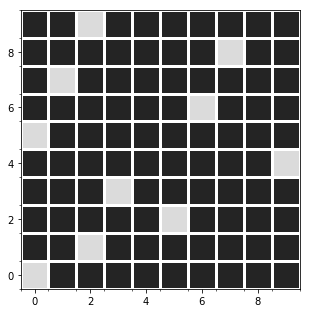

In [77]:
// Start a game

let tree = MCTSTree()

var startingSequence = [tree.root.hold] + (0 ..< 7).map { tree.pieceSequence[$0] }


print("Starting pieces:", startingSequence)
draw(tree.root.field)

In [79]:
// hasSeenTheEnd = false

let thinkTime: TimeInterval = 3


var startTime = Date()

playGame: for move in 1... {
  
  print("*** Move \(move): ***")
  print("Play: \(tree.pieceSequence[0]), hold: \(tree.root.hold)")

//   var searchCount = 0
  startTime = Date()

  while Date().timeIntervalSince(startTime) < thinkTime {
    tree.performParallelSearch(maxBatchSize: 64)
//     tree.performSearch(times: 5)
//     searchCount += 5
  }
  
//   for size in [1, 2, 4, 8, 16, 32, 64, 128] {
//     startTime = Date()
//     tree.performParallelSearch(maxBatchSize: size)
//     print("Search batch of size \(size) took time \(Date().timeIntervalSince(startTime))")
//   }

  let bestChild = tree.root.getMostVisitedChild() ?? tree.root

//   print("Search count: \(searchCount), max depth: \(tree.getMostTraveledPath().count)")
  print("Search count: \(tree.root.childN.sum()), max depth: \(tree.getMostTraveledPath().count)")

  tree.printBestMove()
  
//   print("Tree:")
//   printTree(node: tree.root)
  
  if bestChild.field.garbageCount == 0 {
    print("Garbage cleared!")
    break playGame
  }
  
  if bestChild.field.height >= 20 {
    print("Game over...")
    break playGame
  }
  
  tree.promoteBestChildToRoot()
    
  print()
  
}
  

*** Move 1: ***
Play: I, hold: S
Search count: 162.0, max depth: 3
      X X            
    X X              
  O O   O O O O O O O
  O O O O O O O   O O
  O   O O O O O O O O
  O O O O O O   O O O
    O O O O O O O O O
  O O O O O O O O O  
  O O O   O O O O O O
  O O O O O   O O O O
  O O   O O O O O O O
    O O O O O O O O O

*** Move 2: ***
Play: J, hold: I
Search count: 185.0, max depth: 3
    X X X X          
      O O            
    O O              
  O O   O O O O O O O
  O O O O O O O   O O
  O   O O O O O O O O
  O O O O O O   O O O
    O O O O O O O O O
  O O O O O O O O O  
  O O O   O O O O O O
  O O O O O   O O O O
  O O   O O O O O O O
    O O O O O O O O O

*** Move 3: ***
Play: L, hold: J
Search count: 196.0, max depth: 3
        X X          
        X            
        X            
    O O O O          
      O O            
    O O              
  O O   O O O O O O O
  O O O O O O O   O O
  O   O O O O O O O O
  O O O O O O   O O O
    O O O O O O O O O
  O O

### Explore MCTS result

data count: 43
sums: 42.69456887245178 0.06991910934448242 40.54847955703735


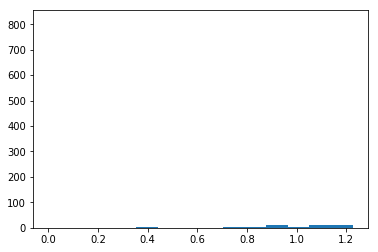

None


In [80]:
// Collect some runtime data for intel

// var data1 = [Double]()
// var data2 = [Double]()
// var data3 = [Double]()

// data1.removeAll(keepingCapacity: true)
// data2.removeAll(keepingCapacity: true)
// data3.removeAll(keepingCapacity: true)

// var data3 = zip(data1, data2).map { $0 + $1 }

plt.hist(data1, bins: 10)
plt.hist(data2, bins: 50)
// plt.hist(data3, bins: 50)

// plt.hist(data1.filter { $0 > 0.05 }, bins: 100)

print("data count:", data1.count)
print("sums:", Tensor(data1).sum(), Tensor(data2).sum(), Tensor(data3).sum())

plt.show()



In [0]:

// tree.performSearch(times: 10000)
// tree.root.getMostVisitedChild()!.getMostVisitedChild()!.childN
// tree.root.puctValue
// tree.root.meanActionValue
// tree.root.childrenActionScores
// tree.root.childW
// tree.root.childN
// tree.root.priors
// tree.root.meanActionValue.max() - tree.root.meanActionValue.min()
// (tree.root.meanActionValue.mean() - 2.5) * 400 / 300

// Check how deep it went
// tree.getMostTraveledPath().forEach { print($0.childN.sum()) }


# Scribbling

In [0]:
// let tree = MCTSTree()
// tree.performSearch(times: 1)

// let (value, priors) = modelEvaluate(field: tree.root.field,
//                                     legalMoves: tree.root.legalMoves,
//                                     hold: .I,
//                                     play: (0...5).map { tree.pieceSequence[$0] })

// (value, priors)